In [86]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d, median_filter
from skimage.morphology import dilation, disk

https://www.scientifica.uk.com/learning-zone/how-to-compute-%CE%B4f-f-from-calcium-imaging-data

# **dF/F₀ Normalization: Using the Neuropil to Get Better Cell Fluorescence Estimates**

Calcium imaging provides a window into the activity of neurons, but raw fluorescence signals are often influenced by baseline fluctuations and background activity from the surrounding tissue. To make these signals interpretable, researchers compute dF/F₀, which represents the fractional change in fluorescence relative to a resting baseline. This transformation highlights calcium transients while minimizing slow drift and background noise.

In this module, you will walk through the core steps for computing dF/F₀ from a single-cell calcium imaging dataset. The workflow includes subtracting the neuropil contribution, estimating a stable baseline (F₀), and using spatial masks to define the cell and its surrounding region. All steps are implemented using just three Python libraries: numpy, scikit-image, and matplotlib.

## **Section 1: Computing dF/F₀ with Neuropil Subtraction (Using NumPy)**

This section focuses on the main transformation used in calcium imaging: computing the relative change in fluorescence, or dF/F₀. The goal is to produce a signal that represents meaningful activity changes, while removing contamination from surrounding neuropil tissue. You will start with raw fluorescence traces from the soma and its surrounding neuropil, then subtract a scaled neuropil signal before normalizing the result using a baseline F₀. These operations are implemented with numpy, allowing for clean and efficient processing of time-series data.

**Subsections**

- **Neuropil Subtraction Using Vectorized NumPy Operations**
Subtract a scaled version of the neuropil trace from the raw fluorescence trace to isolate a cleaner signal.

- **Apply Computed F₀ for Normalization**
Normalize the corrected signal using a dynamic F₀ value obtained from baseline estimation.

- **Visualize Raw, Corrected, and Normalized Traces**
Use matplotlib to plot each step of the transformation pipeline and observe how the signal improves with processing.

**Exercise** Load the data and masks

Load the image stack and binary masks using `tifffile` and `numpy`.

In [4]:
data = tifffile.imread('data/cropped_bottom_neuron_2000frames.tif')
cell_mask = np.load('data/cell_mask_small.npy')
neuropil_mask = np.load('data/neuropil_mask_thin_annulus.npy')

In [5]:
data.shape, cell_mask.shape, neuropil_mask.shape

((2000, 11, 15), (11, 15), (11, 15))

Plotting

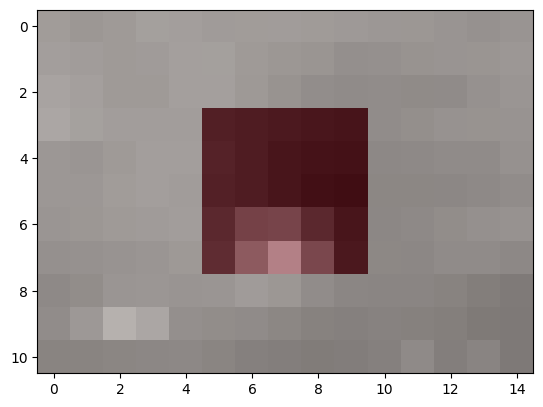

In [9]:
plt.imshow(data.mean(axis=0), cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)

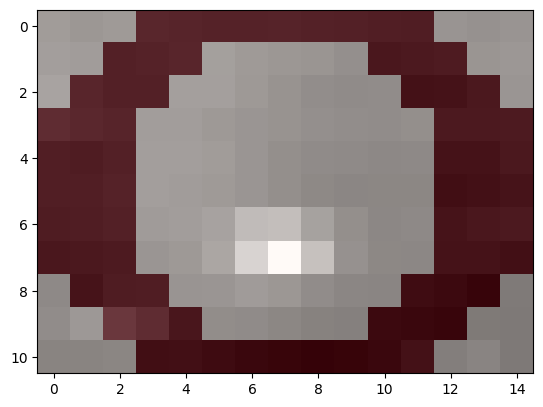

In [10]:
plt.imshow(data.mean(axis=0), cmap='gray')
plt.imshow(neuropil_mask, cmap='Reds', alpha=0.5)

**Exercise** Extract the flourescence time series

Use the binary masks to extract average pixel intensities across time.

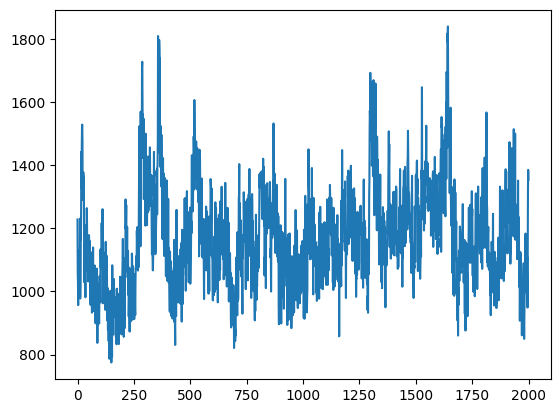

In [28]:
cell_trace = data[:, cell_mask]
cell_trace = np.mean(cell_trace, axis=1)
plt.plot(cell_trace)

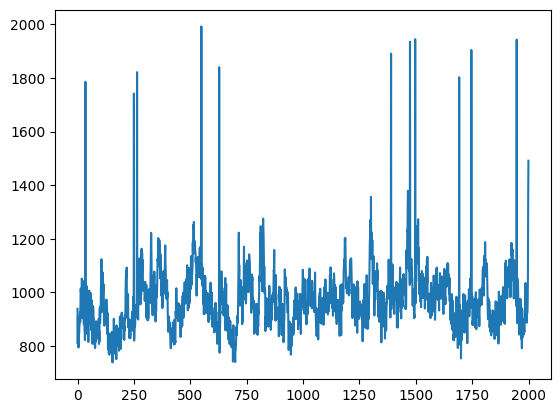

In [29]:
neuropil_trace = data[:, neuropil_mask]
neuropil_trace = np.mean(neuropil_trace, axis=1)
plt.plot(neuropil_trace)

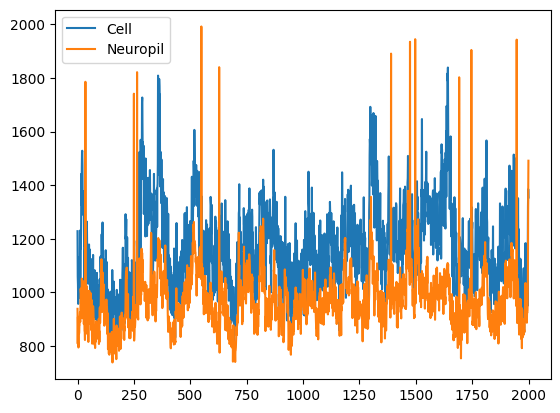

In [30]:
plt.plot(cell_trace, label='Cell')
plt.plot(neuropil_trace, label='Neuropil')
plt.legend();

Neuropil trace seems to be affected by outliers coming from few bright pixels inside the neuropil mask. Let us use median to see if there is any change

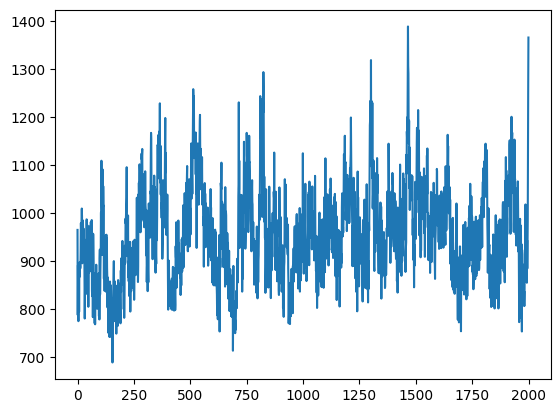

In [31]:
neuropil_trace = data[:, neuropil_mask]
neuropil_trace = np.median(neuropil_trace, axis=1)
plt.plot(neuropil_trace)

**Exercise** Compute df 

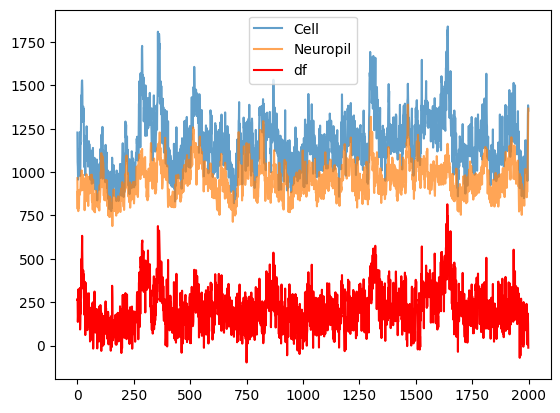

In [32]:
r = 1.0
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

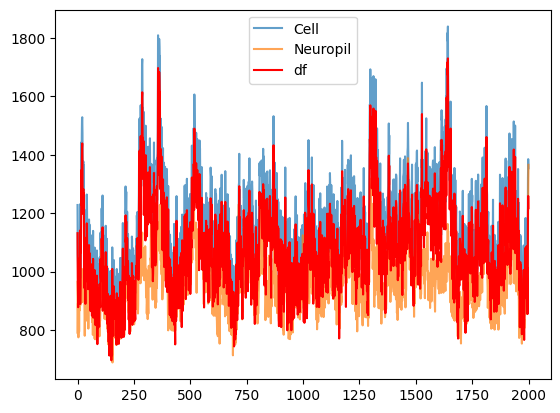

In [33]:
r = 0.1
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

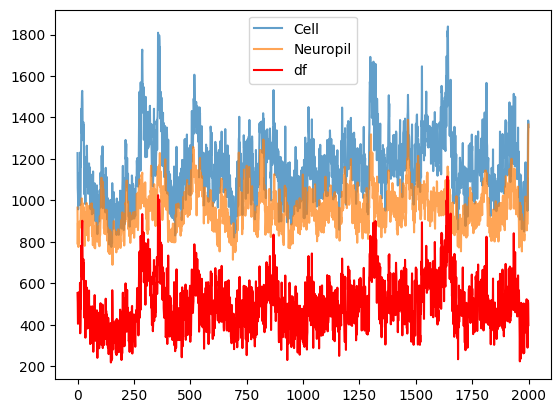

In [34]:
r = 0.7
df = cell_trace - r * neuropil_trace

plt.plot(cell_trace, alpha=0.7, label='Cell')
plt.plot(neuropil_trace, alpha=0.7, label='Neuropil')
plt.plot(df, color='red', label='df')
plt.legend();

**Apply computed F₀ for normalization**

**Exercise** Estimate global F₀ 

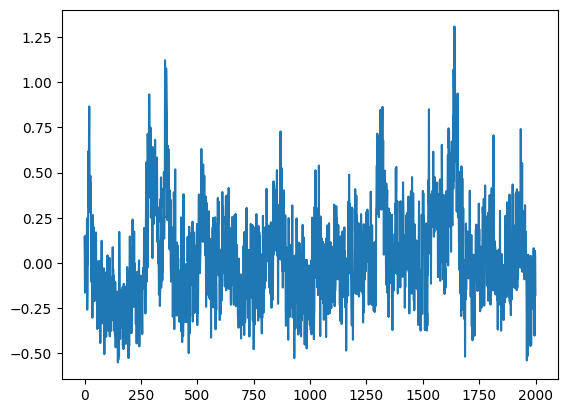

In [40]:
f0 = np.median(df)
dff = (df - f0) / f0

plt.plot(dff)

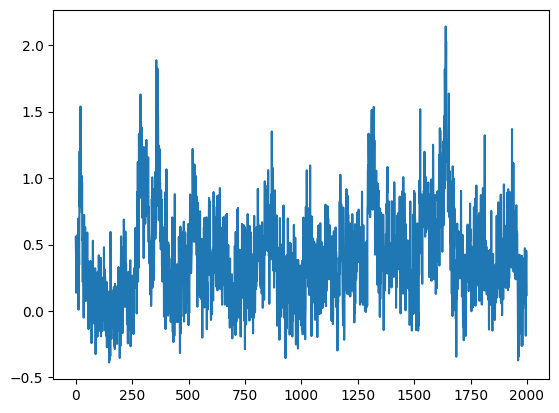

In [41]:
f0 = np.percentile(df, 10)
dff = (df - f0) / f0

plt.plot(dff)

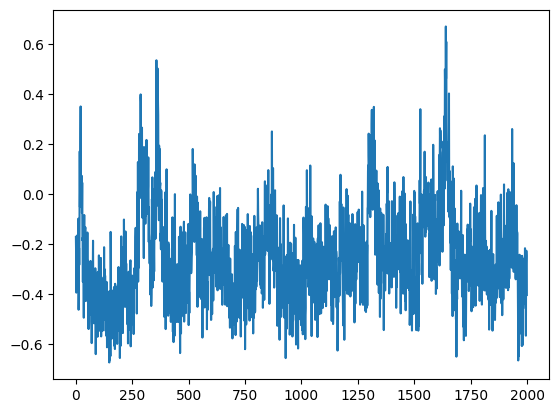

In [42]:
f0 = np.percentile(df, 90)
dff = (df - f0) / f0

plt.plot(dff)

## **Section 2: Estimating Baseline Fluorescence (F₀) Using Moving Averages**

Estimating the baseline fluorescence (F₀) accurately is key to producing meaningful dF/F₀ traces. In this section, you will explore three baseline estimation strategies based on rolling window operations: the average, the median, and a low percentile. These approaches are useful because they can adapt to slow changes in the signal while ignoring fast calcium transients.

Each method computes F₀ by looking at a local window of past and future frames, helping reduce noise and account for drift.

**Subsections:**
- **Rolling Average**  
  Use a sliding window to compute an average value over time, which helps avoid bias from transient events.
  
- **Rolling Median**  
  Use a sliding window to compute a median value over time, which helps avoid bias from transient events.

- **Rolling Window Percentile-Based Baseline**  
  Apply exponential smoothing to adaptively follow the baseline, offering a trade-off between responsiveness and stability.


**Rolling Average (Uniform Filter)**

**Exercise** Apply a uniform filter for the rolling average

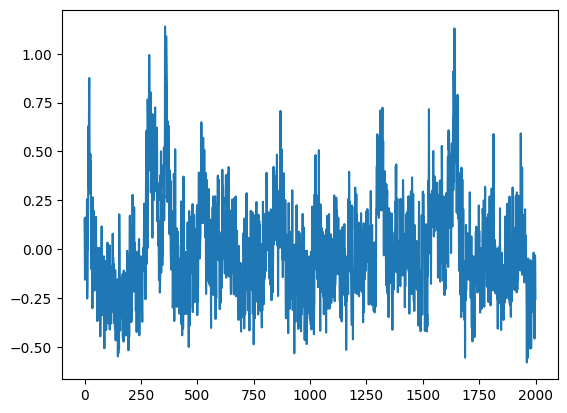

In [50]:
window_size = 1000
f0 = uniform_filter1d(df, size=window_size)
dff = (df - f0) / f0

plt.plot(dff)

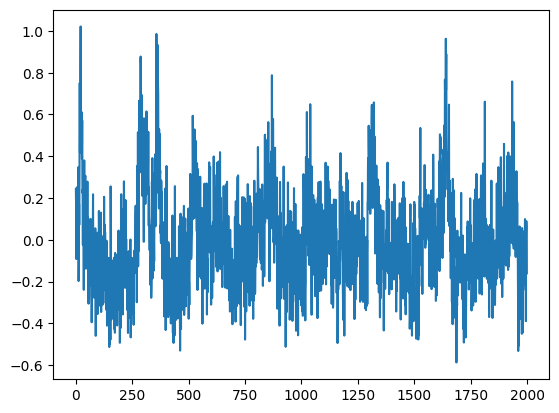

In [51]:
window_size = 300
f0 = uniform_filter1d(df, size=window_size)
dff = (df - f0) / f0

plt.plot(dff)

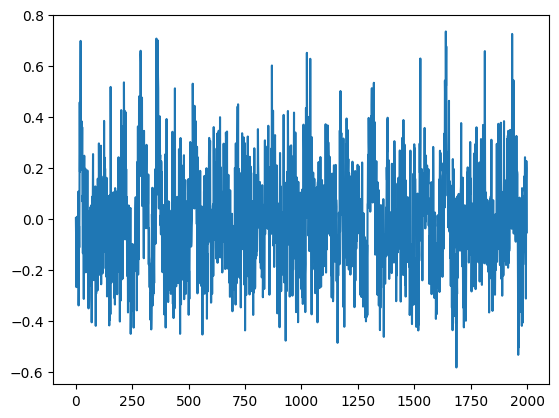

In [52]:
window_size = 100
f0 = uniform_filter1d(df, size=window_size)
dff = (df - f0) / f0

plt.plot(dff)

**Exercise** Apply a rolling median filter

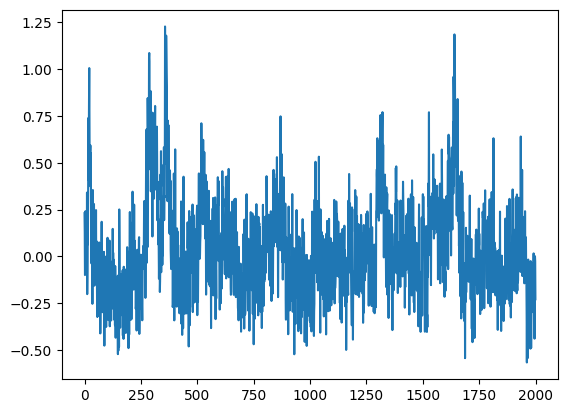

In [56]:
window_size = 1001
f0 = median_filter(df, size=window_size)
dff = (df - f0) / f0

plt.plot(dff)

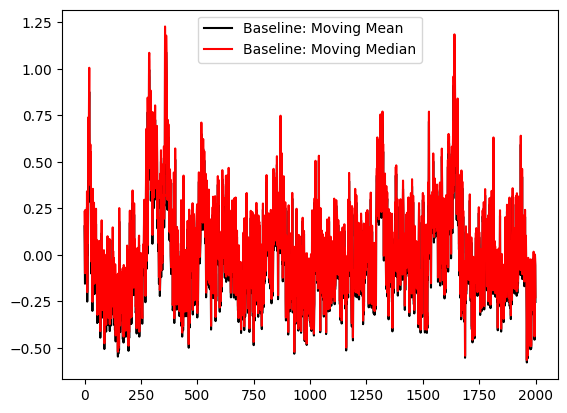

In [62]:
window_size = 1001
f0_median = median_filter(df, size=window_size)
f0_mean = uniform_filter1d(df, size=window_size)

dff_mean = (df - f0_mean) / f0_mean
dff_median = (df - f0_median) / f0_median

plt.plot(dff_mean, color='k', label='Baseline: Moving Mean')
plt.plot(dff_median, color='r', label='Baseline: Moving Median')
plt.legend();

**Exercise** Rolling Percentile-Based

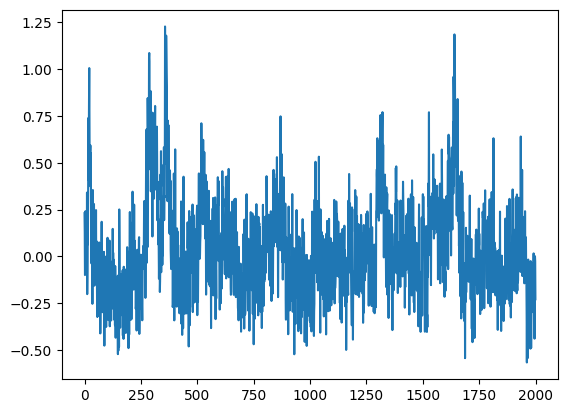

In [70]:
f0_percentile = np.full_like(df, np.nan, dtype=float)

for i in range(len(df)):
    start = max(0, i - window_size // 2)
    end = min(len(df), i + window_size // 2)
    f0_percentile[i] = np.percentile(df[start:end], 10)

dff = (df - f0) / f0
plt.plot(dff);

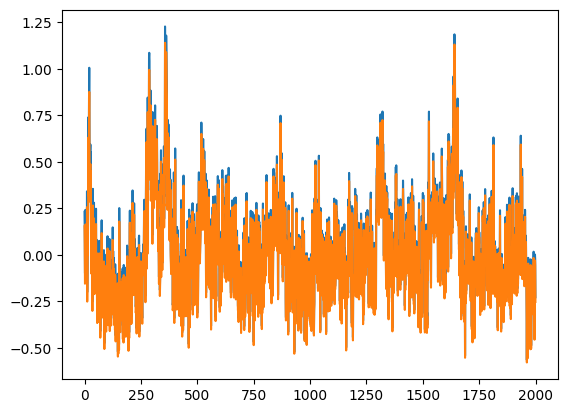

In [71]:
plt.plot(dff)
plt.plot(dff_mean)

## **Section 3: Defining Cell and Neuropil Regions (Using scikit-image)**

To compute accurate fluorescence signals, you must first define the spatial regions that correspond to the neuron and the surrounding neuropil. Even in single-cell recordings, nearby processes and background structures contribute to fluorescence measurements. In this section, you will use image processing tools from scikit-image to create, from the soma, a ring-shaped neuropil region. These masks can then be applied to an image stack to extract mean fluorescence signals over time.

**Preprocessing and Image Enhancement**

We will use the mean image across time as a summary projection, and apply filters to prepare for segmentation.

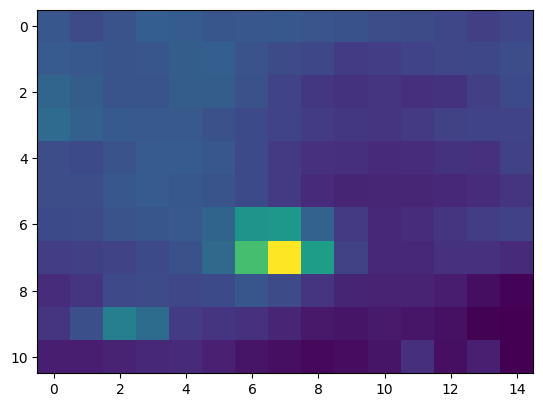

In [73]:
mean_proj = data.mean(axis=0)
plt.imshow(mean_proj)

In [83]:
mask_abs = mean_proj > 1500
cell_mask = mask_abs.astype(bool)

**Exercise** Dilate the cell mask outward

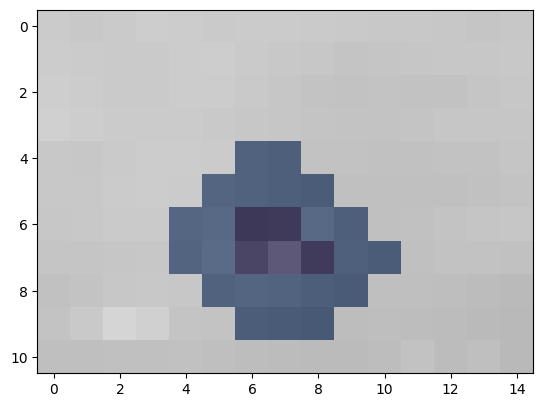

In [102]:
dilated_mask = dilation(cell_mask, disk(2))
plt.imshow(mean_proj, cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask, cmap='Blues', alpha=0.5)

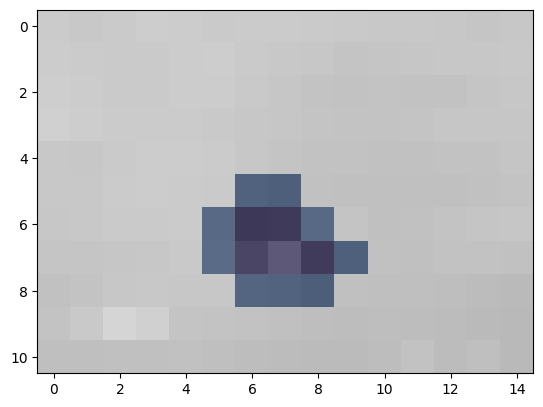

In [94]:
dilated_mask = dilation(cell_mask, disk(1))
plt.imshow(mean_proj, cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask, cmap='Blues', alpha=0.5)

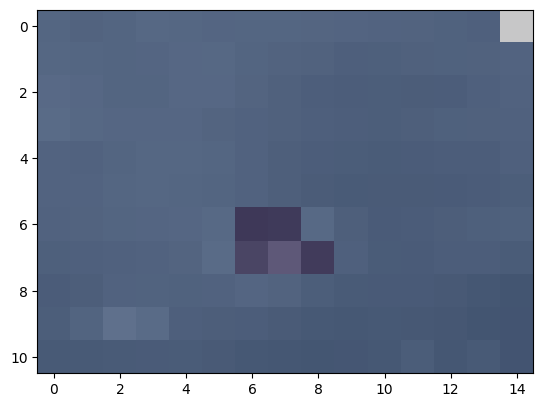

In [100]:
dilated_mask = dilation(cell_mask, disk(9))
plt.imshow(mean_proj, cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask, cmap='Blues', alpha=0.5)

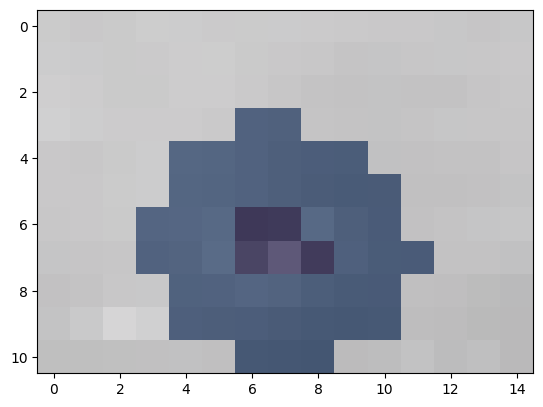

In [103]:
dilated_mask = dilation(cell_mask, disk(3))
plt.imshow(mean_proj, cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)
plt.imshow(dilated_mask, cmap='Blues', alpha=0.5)

**Exercise** Subtract the soma to form a ring

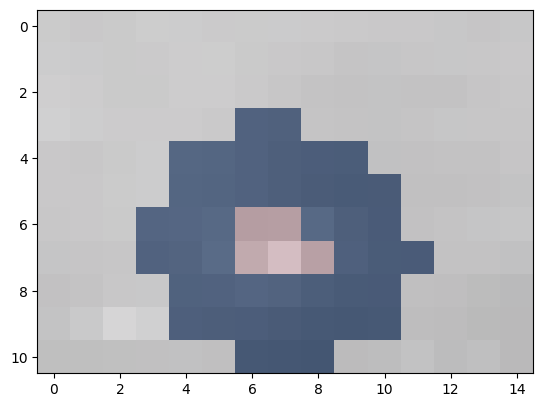

In [107]:
neuropil_mask = dilated_mask & (~cell_mask)
plt.imshow(mean_proj, cmap='gray')
plt.imshow(cell_mask, cmap='Reds', alpha=0.5)
plt.imshow(neuropil_mask, cmap='Blues', alpha=0.5)